In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils.model_utils import ResidualAttentionNetwork
from utils.model_utils import AttentionActivationType, AttentionModule, LearningOutput
from matplotlib import pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
cifar100_dataset = tf.keras.datasets.cifar100
(X_train, y_train), (X_test, y_test) = cifar100_dataset.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_test.shape)
print('Validation labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 100)
Validation data shape:  (10000, 32, 32, 3)
Validation labels shape:  (10000, 100)


In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# For CIFAR 100 dataset, the mean and standard deviation
# values for every channel:
mean = [129.3, 124.1, 112.4]
std = [68.2, 65.4, 70.4]

# X - mean / std
for i in range(3):
    X_train[:,:,:,i] = (X_train[:,:,:,i] - mean[i]) / std[i]
    X_test[:,:,:,i] = (X_test[:,:,:,i] - mean[i]) / std[i]

# Using data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             validation_split=0.2)

datagen.fit(X_train)

input_shape = X_train.shape[1:]
output_size = 100

In [10]:
"""
Dataset: Cifar100
Model: Attention-56 with pre-activation Residual Unit, Attention Residual Learning
Optimizer: Adam
Batch size = 64
epochs = 250
"""

residual_attention_network = ResidualAttentionNetwork(input_shape=input_shape, output_size=output_size,
                                                      attention_model=AttentionModule.ATTENTION56,
                                                      attention_activation_type=AttentionActivationType.SPATIAL_ATTENTION)
model = residual_attention_network.attention_mod()
model.compile(tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

callback_accuracy = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 32, 32, 64)   4864        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_135[0][0]                 
__________________________________________________________________________________________________
batch_normalization_97 (BatchNo (None, 16, 16, 64)   256         max_pooling2d_7[0][0]            
____________________________________________________________________________________________

In [12]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64, subset='training'),
                    validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
                    epochs=250, callbacks=[callback_accuracy])

Epoch 1/250
625/625 [==============================] - 63s 86ms/step - loss: 4.2494 - accuracy: 0.0454 - val_loss: 4.1571 - val_accuracy: 0.0715
Epoch 2/250
625/625 [==============================] - 51s 82ms/step - loss: 3.8734 - accuracy: 0.0878 - val_loss: 4.2066 - val_accuracy: 0.0926
Epoch 3/250
625/625 [==============================] - 51s 82ms/step - loss: 3.6803 - accuracy: 0.1182 - val_loss: 3.6432 - val_accuracy: 0.1230
Epoch 4/250
625/625 [==============================] - 51s 82ms/step - loss: 3.5432 - accuracy: 0.1398 - val_loss: 3.8332 - val_accuracy: 0.1121
Epoch 5/250
625/625 [==============================] - 51s 82ms/step - loss: 3.4272 - accuracy: 0.1593 - val_loss: 3.4225 - val_accuracy: 0.1586
Epoch 6/250
625/625 [==============================] - 51s 81ms/step - loss: 3.3180 - accuracy: 0.1728 - val_loss: 3.9914 - val_accuracy: 0.1238
Epoch 7/250
625/625 [==============================] - 51s 81ms/step - loss: 3.2087 - accuracy: 0.1917 - val_loss: 3.4610 - val_ac

In [13]:
# Evaluate model
model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 7s 15ms/step - loss: 1.7788 - accuracy: 0.5477


[1.7787835597991943, 0.5476999878883362]

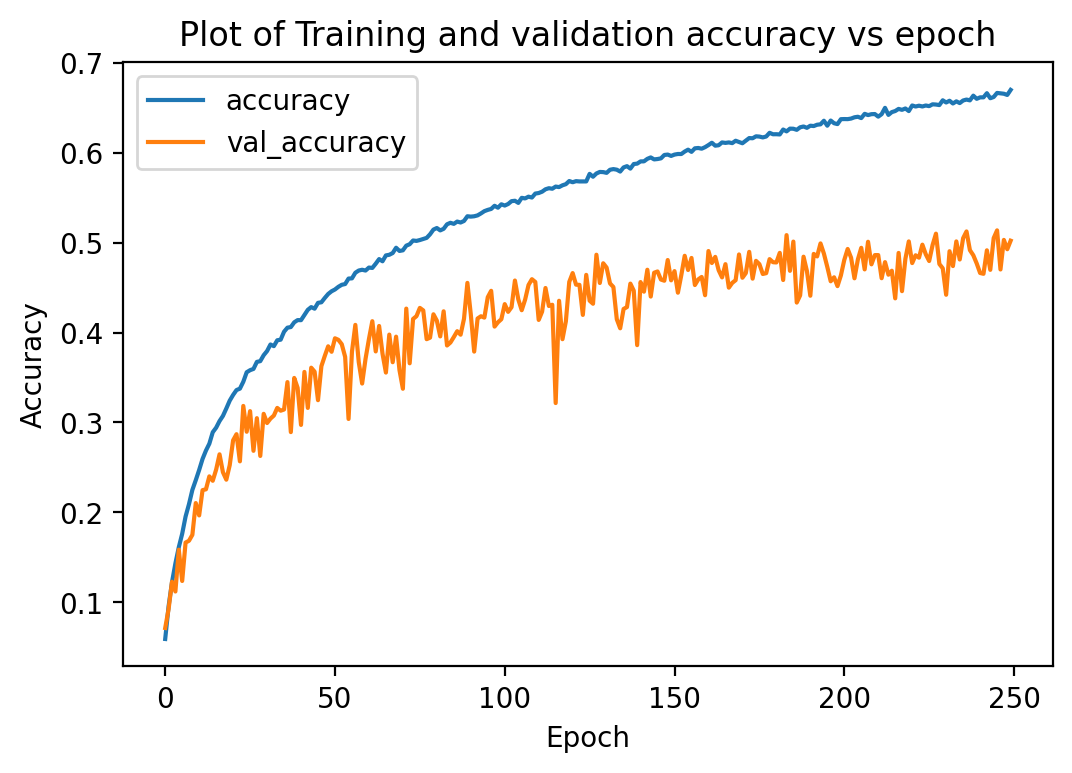

In [14]:
#Plot accuracy
fig = plt.figure(figsize=(6, 4), dpi=200)
plt.title("Plot of Training and validation accuracy vs epoch")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('Cifar100_Attn56_accplot.png')
plt.legend(loc='upper left')
plt.show()

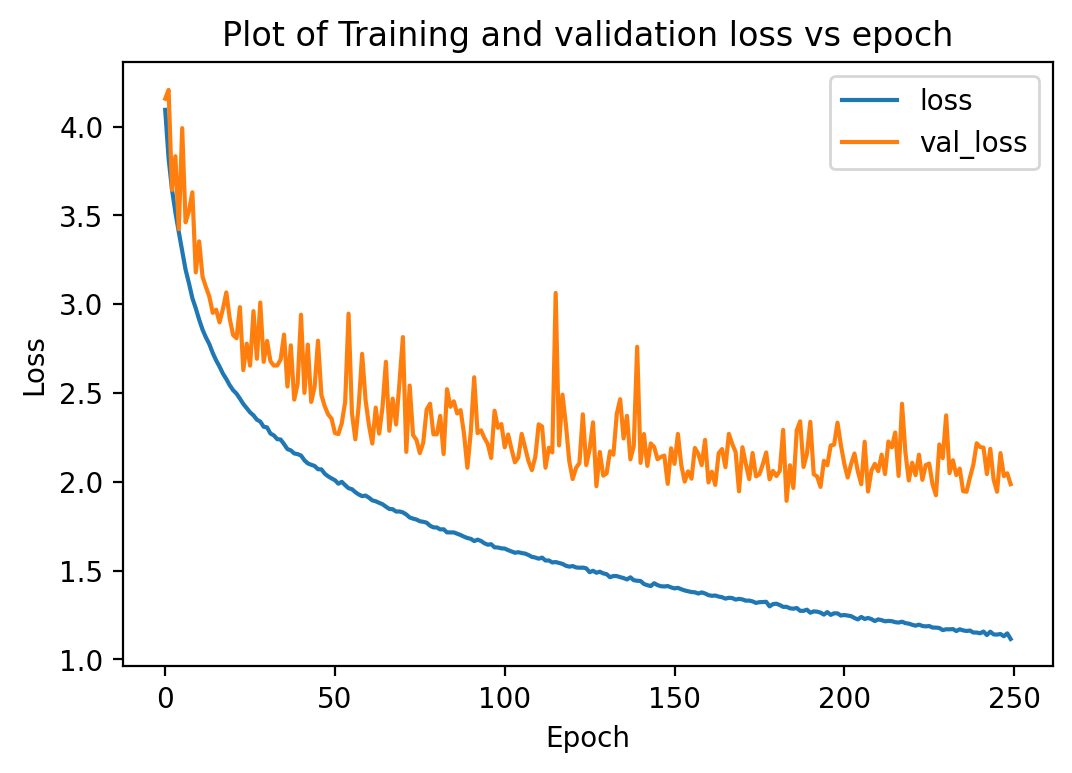

In [15]:
#Plot loss
fig = plt.figure(figsize=(6, 4), dpi=200)
plt.title("Plot of Training and validation loss vs epoch")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('Cifar100_Attn56_lossplot.png')
plt.legend(loc='upper right')
plt.show()

In [17]:
# cifar<10or100>_attn<56or92>_<lrn-mech>_<attn-act-type>.h5
model.save(filepath = "./model/cifar100_attn56_attn-res-lrn_spatial")

INFO:tensorflow:Assets written to: ./model/cifar100_attn56_attn-res-lrn_spatial/assets
